## Block 1 — Load/merge panel, standardize keys, quick summary
Load the pre-merged panel (`Zc_occ_with_env_2010_2018.csv`) or merge occupancy and drivers by `site` and `date`.  
Robustly detect and normalize column names to canonical `site` and `date`, coerce dates, and auto-detect the ZC target column (`p`/`occupancy`).  
Print the overall date span and a sample of site names to confirm the dataset is ready for per-site modeling (e.g., Cairns).


In [1]:
# BLOCK 1 — Load + Merge (if needed) + Standardize columns + Quick summary

import os
import numpy as np
import pandas as pd

# ---------- helpers ----------
def pick_col(cols, candidates):
    """Return the first column in `cols` that matches any in `candidates` (case-insensitive)."""
    low = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in low:
            return low[cand.lower()]
    return None

def ensure_datetime(df, colname):
    df[colname] = pd.to_datetime(df[colname])
    return df

def find_site_col(cols):
    """Robustly detect the site column from common classroom/CSV variants."""
    exact = ["site","survey_nam","survey_name","site_name","location","station",
             "station_name","sitename","siteid","site_id","site id","name","site name"]
    # 1) direct exact (case-insensitive)
    for c in cols:
        if c.lower() in exact:
            return c
    # 2) normalized
    def norm(s): return "".join(ch for ch in s.lower() if ch.isalnum())
    normalized_targets = {"site","sitename","siteid","surveynam","surveyname",
                          "location","station","stationname"}
    for c in cols:
        if norm(c) in normalized_targets:
            return c
    # 3) contains-based fallback
    for c in cols:
        cl = c.lower()
        if any(tok in cl for tok in ["site","survey","station","location"]):
            return c
    return None

# ---------- file paths (as uploaded) ----------
p_merged = "Zc_occ_with_env_2010_2018.csv"
p_occ    = "Zc_monthly_occupancy_2010_2018.csv"
p_env    = "env_drivers_pivot_2010_2018.csv"

# ---------- load: prefer merged, otherwise merge by (site, date) ----------
if os.path.exists(p_merged):
    df = pd.read_csv(p_merged)
    print(f"Loaded merged file: {p_merged}")
else:
    if not (os.path.exists(p_occ) and os.path.exists(p_env)):
        raise FileNotFoundError("Neither merged file nor both component files were found.")
    occ = pd.read_csv(p_occ)
    env = pd.read_csv(p_env)

    site_occ = find_site_col(occ.columns)
    date_occ = pick_col(occ.columns, ["date","month_date","time"])
    site_env = find_site_col(env.columns)
    date_env = pick_col(env.columns, ["date","month_date","time"])

    if not all([site_occ, date_occ, site_env, date_env]):
        raise ValueError(
            f"Cannot find site/date keys. "
            f"occ columns: {list(occ.columns)[:12]}... | env columns: {list(env.columns)[:12]}..."
        )

    occ = occ.rename(columns={site_occ: "site", date_occ: "date"})
    env = env.rename(columns={site_env: "site", date_env: "date"})
    occ = ensure_datetime(occ, "date")
    env = ensure_datetime(env, "date")

    df = occ.merge(env, on=["site","date"], how="left")
    print("Merged occupancy + environment from two files.")

# ---------- standardize 'site' + 'date', find target column ----------
# Re-detect/rename 'site' in case merged file used another header
site_col = find_site_col(df.columns)
if site_col is None:
    raise ValueError(f"Could not detect the site column. Columns: {list(df.columns)}")
if site_col != "site":
    df = df.rename(columns={site_col: "site"})
    print(f"Renamed '{site_col}' → 'site'")

if "date" not in df.columns:
    # try to find a date column if merged had a different name
    date_alt = pick_col(df.columns, ["date","month_date","time"])
    if date_alt is None:
        raise ValueError("No date-like column found.")
    df = df.rename(columns={date_alt: "date"})

df["date"] = pd.to_datetime(df["date"])

target = pick_col(df.columns, ["p","p_zc","zc_p","occ","occupancy"])
if target is None:
    raise ValueError("Target column for Zc occupancy not found (expected 'p' / 'occupancy' etc.)")

# ---------- quick summary ----------
print(f"\nTarget column = {target}")
print("Date range:", df["date"].min().date(), "→", df["date"].max().date())

sites_list = (df["site"].dropna().astype(str).str.strip()
                .drop_duplicates().sort_values().tolist())
print(f"Found {len(sites_list)} sites. Sample:", sites_list[:10])

Loaded merged file: Zc_occ_with_env_2010_2018.csv
Renamed 'SURVEY_NAM' → 'site'

Target column = p
Date range: 2010-02-01 → 2018-12-01
Found 8 sites. Sample: ['Abbot_Point', 'Cairns', 'Clairview', 'Gladstone', 'HayPoint', 'Mourilyan', 'OSRA', 'Townsville']


## Block 2 — Filter Cairns, build lags, and prepare predictors for modeling
Subset to **Cairns** and coerce dates. Ensure `eta` exists, then create 1-month lags for **salinity** and **current speed**.  
Aggregate to month-start means and drop rows with missing values introduced by lagging.  
Final predictors used for the model: **salt_lag1**, **eta**, **current_speed_lag1**; target is the detected ZC occupancy column.  
Output `d_site` is a tidy monthly table ready for PCA and SARIMAX.


In [2]:
# BLOCK 2 — Filter Townsville, create lags, monthly-aggregate, final tidy (fixed)

import pandas as pd
import numpy as np
from IPython.display import display  # ensure display() works

# Safety checks (requires BLOCK 1 to have defined `df` and `target`)
assert 'df' in globals(), "Run BLOCK 1 first to load/merge data."
assert 'target' in globals(), "Run BLOCK 1 first to detect the target column."

SITE = "Cairns"

def ensure_eta(frame: pd.DataFrame) -> pd.DataFrame:
    """Ensure an 'eta' column exists; rename common variants if necessary."""
    if "eta" in frame.columns:
        return frame
    candidates = [c for c in frame.columns if c.lower().startswith("eta")]
    if candidates:
        return frame.rename(columns={candidates[0]: "eta"})
    for alt in ["sea_level","sea_level_mean","water_level","waterlevel","eta_mean","eta(m)"]:
        if alt in frame.columns:
            return frame.rename(columns={alt: "eta"})
    raise ValueError("Column 'eta' not found (no close variant matched).")

def add_lag_if_missing(frame: pd.DataFrame, src: str, lag_name: str, group="site", lag=1) -> pd.DataFrame:
    """Create a lagged column if not already present, grouping by site and shifting by 1 month."""
    if lag_name in frame.columns:
        return frame
    if src not in frame.columns:
        cands = [c for c in frame.columns if c.lower().startswith(src.lower())]
        if not cands:
            raise ValueError(f"Cannot find source column for '{lag_name}'. Need '{src}' (or close variant).")
        src = cands[0]
    frame = frame.sort_values(["site","date"]).copy()
    frame[lag_name] = frame.groupby(group, dropna=False)[src].shift(lag)
    return frame

def monthly_mean(frame: pd.DataFrame, keep_cols: list) -> pd.DataFrame:
    """
    Aggregate to monthly (MonthStart). For numeric columns, take mean.
    For 'site', forward/back-fill after aggregation.
    """
    f = frame[keep_cols].copy()
    f["date"] = pd.to_datetime(f["date"])
    f["date"] = f["date"].values.astype("datetime64[M]")  # snap to 1st-of-month
    num_cols = [c for c in keep_cols if c not in ["site","date"]]
    g = (f.groupby("date")[num_cols].mean().sort_index())
    idx = pd.date_range(g.index.min(), g.index.max(), freq="MS")
    g = g.reindex(idx)
    g.index.name = "date"
    g["site"] = SITE
    cols_ordered = ["site"] + num_cols
    g = g.reset_index()[["date"] + cols_ordered]
    return g

# 2.1 Filter the site
if "site" not in df.columns or "date" not in df.columns:
    raise ValueError("Expected 'site' and 'date' in df. Re-run BLOCK 1.")
d_site = df.loc[df["site"].astype(str).str.strip().str.lower() == SITE.lower()].copy()
if d_site.empty:
    avail = (df["site"].dropna().astype(str).str.strip().unique().tolist())
    raise ValueError(f"No rows for site='{SITE}'. Available sites (first 20): {avail[:20]}")
d_site["date"] = pd.to_datetime(d_site["date"])

print(f"[{SITE}] rows before tidy:", len(d_site))

# 2.2 Ensure eta and create lags
d_site = ensure_eta(d_site)
d_site = add_lag_if_missing(d_site, src="salt",          lag_name="salt_lag1",          group="site", lag=1)
d_site = add_lag_if_missing(d_site, src="current_speed", lag_name="current_speed_lag1", group="site", lag=1)

# 2.3 Keep necessary columns and monthly-aggregate
need_cols = ["site","date", target, "salt_lag1","eta","current_speed_lag1"]
missing = [c for c in need_cols if c not in d_site.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

d_site = monthly_mean(d_site, keep_cols=need_cols)

# 2.4 Drop rows with NaNs in target or exog (typical at the series start due to lag)
n0 = len(d_site)
d_site = d_site.dropna(subset=[target,"salt_lag1","eta","current_speed_lag1"]).reset_index(drop=True)
print(f"[{SITE}] kept {len(d_site)}/{n0} monthly rows after dropna.")

# 2.5 Final preview
print("Date span:", d_site["date"].min().date(), "→", d_site["date"].max().date())
print("Columns:", d_site.columns.tolist())
display(d_site.head(8))

[Cairns] rows before tidy: 24
[Cairns] kept 23/99 monthly rows after dropna.
Date span: 2010-11-01 → 2018-12-01
Columns: ['date', 'site', 'p', 'salt_lag1', 'eta', 'current_speed_lag1']


,date,site,p,salt_lag1,eta,current_speed_lag1
0,2010-11-01,Cairns,0.014493,34.451576,0.149694,0.001779
1,2010-12-01,Cairns,0.000000,33.779603,0.022938,0.001147
2,2011-09-01,Cairns,0.068966,31.475793,0.006195,0.006747
3,2011-10-01,Cairns,0.000000,34.350311,0.060105,0.001736
4,2012-10-01,Cairns,0.007371,34.435663,0.020676,0.000678
5,2012-11-01,Cairns,0.000000,35.095769,-0.039684,0.002265
6,2013-01-01,Cairns,0.000000,35.628113,-0.031901,0.001357
7,2013-10-01,Cairns,0.034188,34.239143,0.030140,0.002796


## Block 3  — PCA on target and three predictors (Cairns)
Run PCA on **ZC occupancy `p`** and predictors **salt_lag1**, **eta**, **current_speed_lag1** for **Cairns**.  
Resolve column aliases, filter to the site, resample to month-start means, handle infinities, and interpolate gaps.  
Standardize features, fit **PCA(n=2)**, report explained variance, then plot a time-colored PC1–PC2 scatter and a biplot with loadings.  
Outputs: `PCA_scatter_Cairns.png` and `PCA_biplot_Cairns.png`.


Resolved columns: {'p': 'p', 'salt_lag1': 'salt_l1', 'eta': 'eta', 'current_speed_lag1': 'current_speed_l1'}
Using site: Cairns
Explained variance ratio: PC1=0.448, PC2=0.296


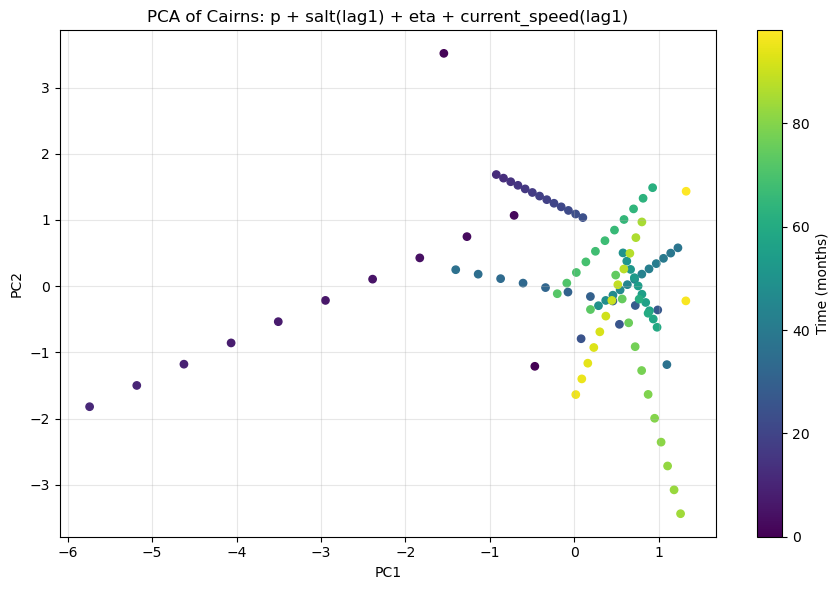

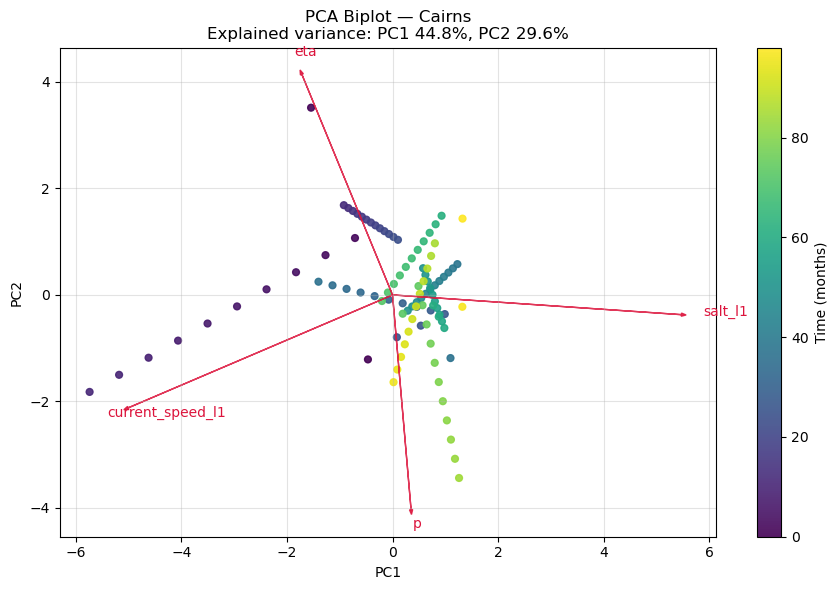

In [6]:
# === PCA: p + (salt lag1, eta or eta_l1, current_speed lag1) — robust to your column names ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df['site'] = df['site'].astype(str).str.strip()


def pick_col(cols, candidates):
    """Return the first existing column among candidate names (case/underscore tolerant)."""
    norm = lambda s: "".join(ch for ch in s.lower() if ch.isalnum())
    col_norm = {norm(c): c for c in cols}
    for cand in candidates:
        if norm(cand) in col_norm:
            return col_norm[norm(cand)]
    # contains fallback
    for c in cols:
        if any(norm(tok) in norm(c) for tok in candidates):
            return c
    return None

p_col   = pick_col(df.columns, ['p','psi','occupancy','occ','p_hat','p_est'])
salt1   = pick_col(df.columns, ['salt_lag1','salt_l1','sal_lag1','sal_l1','salinity_l1'])
eta_col = pick_col(df.columns, ['eta','eta_l1','sea_level','sea_level_l1'])
cs1     = pick_col(df.columns, ['current_speed_lag1','current_speed_l1','currspd_lag1','currspd_l1'])

used = {'p': p_col, 'salt_lag1': salt1, 'eta': eta_col, 'current_speed_lag1': cs1}
print("Resolved columns:", used)

missing = [k for k,v in used.items() if v is None]
if missing:
    raise KeyError(f"{missing}\n{list(df.columns)}")

# ---- 2) 
SITE = "Cairns"  # 

mask = df['site'].astype(str).str.strip().str.casefold() == SITE.casefold()
dsite = df[mask].copy()

if dsite.empty:
    avail = sorted(df['site'].astype(str).str.strip().unique())
    raise ValueError(f"No rows found for site '{SITE}'. Check spelling. Available: {avail}")

print("Using site:", SITE)

X = (dsite.sort_values('date')
          .set_index('date')[[p_col, salt1, eta_col, cs1]]
          .resample('MS').mean()
          .replace([np.inf, -np.inf], np.nan)
          .interpolate(limit_direction='both'))


stds = X.std()
if (stds == 0).any():
    print( list(stds[stds==0].index))
    X = X.loc[:, stds > 0]


Z = StandardScaler().fit_transform(X.values)
pca = PCA(n_components=2, random_state=0)
PC  = pca.fit_transform(Z)
exp = pca.explained_variance_ratio_
print(f"Explained variance ratio: PC1={exp[0]:.3f}, PC2={exp[1]:.3f}")

pc_df = pd.DataFrame(PC, index=X.index, columns=['PC1','PC2'])
loads = pca.components_.T * np.sqrt(pca.explained_variance_)
load_df = pd.DataFrame(loads, index=X.columns, columns=['PC1','PC2'])

t_idx = np.arange(len(pc_df))
plt.figure(figsize=(9,6))
plt.scatter(pc_df['PC1'], pc_df['PC2'], c=t_idx, cmap='viridis', s=28)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title(f'PCA of {SITE}: p + salt(lag1) + eta + current_speed(lag1)')
cb = plt.colorbar(); cb.set_label('Time (months)')
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(f'PCA_scatter_{SITE}.png', dpi=300)
plt.show()


sx = (pc_df['PC1'].max() - pc_df['PC1'].min()) * 0.8
sy = (pc_df['PC2'].max() - pc_df['PC2'].min()) * 0.8
scale = min(sx, sy) / (np.max(np.abs(loads)) + 1e-9)

plt.figure(figsize=(9,6))
plt.scatter(pc_df['PC1'], pc_df['PC2'], c=t_idx, cmap='viridis', s=24, alpha=0.9)
for var, (lx, ly) in load_df[['PC1','PC2']].iterrows():
    dx, dy = lx*scale, ly*scale
    plt.arrow(0, 0, dx, dy, color='crimson', alpha=0.85,
              width=0.0, head_width=0.06, length_includes_head=True)
    plt.text(dx*1.06, dy*1.06, var, color='crimson', fontsize=10)

plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title(f'PCA Biplot — {SITE}\nExplained variance: PC1 {exp[0]:.1%}, PC2 {exp[1]:.1%}')
cb = plt.colorbar(); cb.set_label('Time (months)')
plt.grid(True, alpha=0.35); plt.tight_layout()
plt.savefig(f'PCA_biplot_{SITE}.png', dpi=300)
plt.show()

## Block — Train–test split (Cairns)
Split the ordered series into **train = all but last 12 months** and **test = final 12 months**.  
Preserves temporal order to avoid leakage and enables out-of-sample evaluation of forecasts.


In [4]:
train = df.iloc[:-12]
test  = df.iloc[-12:]

## Block — SARIMAX with dynamic future exogenous (Cairns)
Monthly **p ~ SARIMAX(1,0,1) × (1,0,1,12)** with exogenous **salt_l1**, **eta**, **current_speed_l1**.  
Resolve column aliases, filter `site="Cairns"`, resample to month-start means, and keep data up to **2018-12** for fitting.  
Project each exogenous 60 months ahead (2019–2023) using OLS **trend + annual sine/cos**, then forecast p with SARIMAX; clip mean and CI to **[0,1]** and plot past vs future.




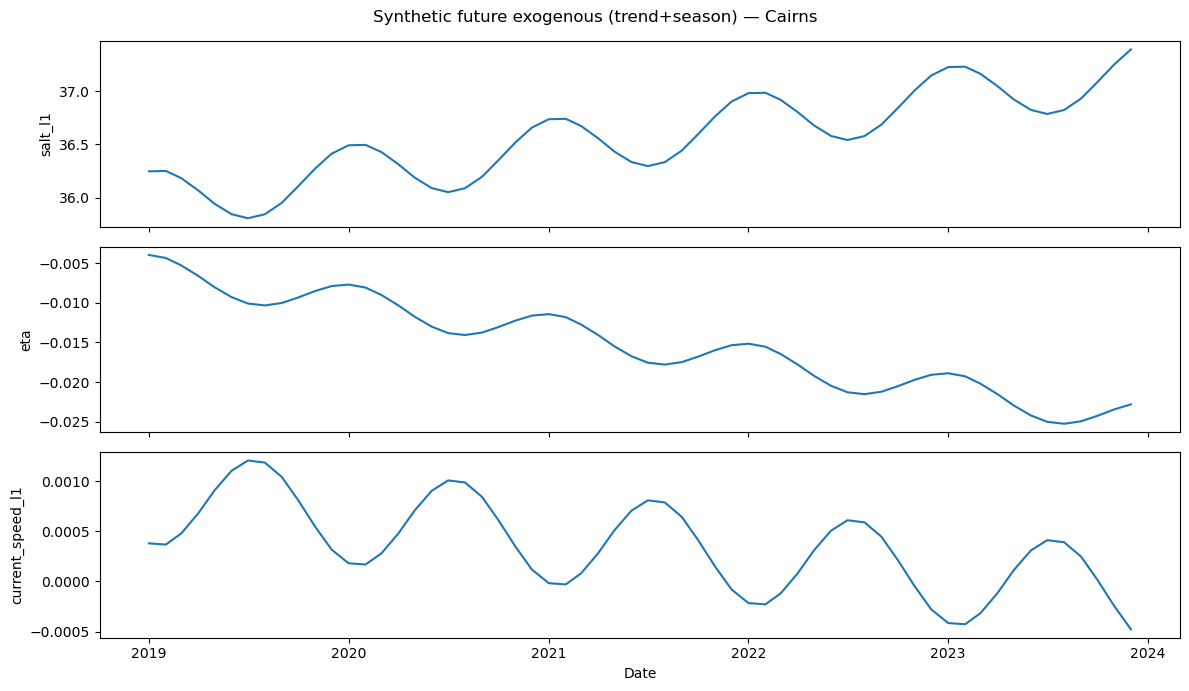

D:\Users\F\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


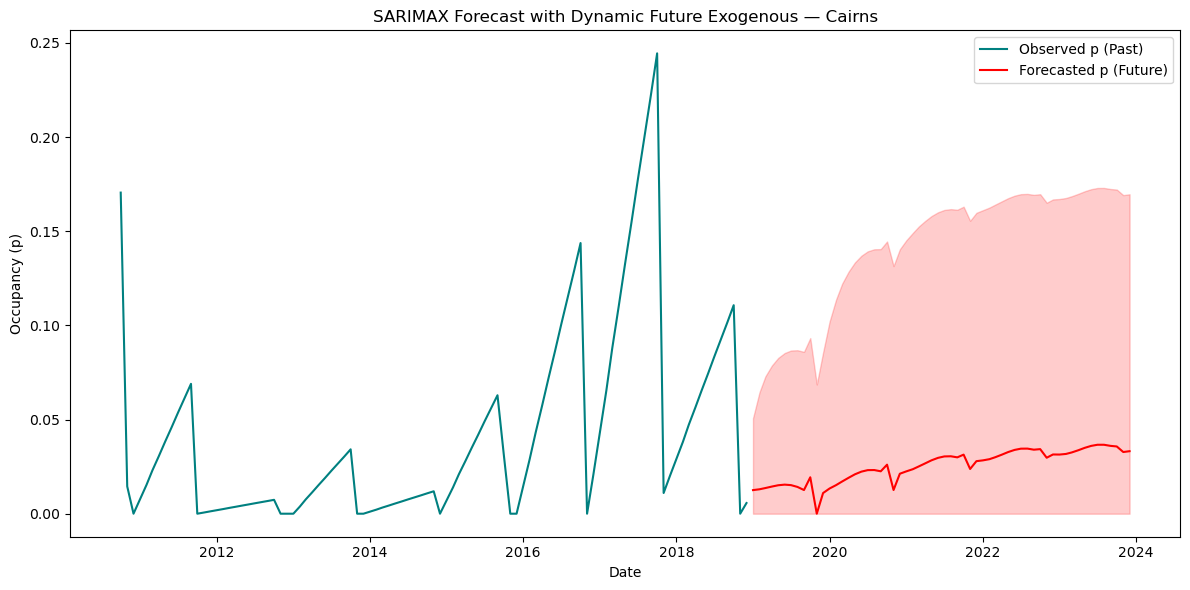

In [5]:
# ================================
# Monthly SARIMAX with dynamic future drivers (class-style)
# p ~ ARIMA + exog [salt_l1, eta, current_speed_l1]
# Future exog = linear trend + seasonal sine/cos fitted from history
# ================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

SITE = "Cairns"      # change if needed
SEASON = 12              # monthly → yearly seasonality
FORECAST_MONTHS = 60     # 5 years (2019–2023)

# ---- Resolve columns (handles aliases) ----
def pick_col(cols, candidates):
    norm = lambda s: "".join(ch for ch in s.lower() if ch.isalnum())
    c2orig = {norm(c): c for c in cols}
    for cand in candidates:
        key = norm(cand)
        if key in c2orig: return c2orig[key]
    for c in cols:
        if any(norm(tok) in norm(c) for tok in candidates): return c
    return None

df1 = df.copy()
df1["date"] = pd.to_datetime(df1["date"])
df1["site"] = df1["site"].astype(str).str.strip()

p_col  = pick_col(df1.columns, ["p","psi","occupancy"])
salt1  = pick_col(df1.columns, ["salt_l1","salt_lag1","sal_l1","sal_lag1"])
eta_c  = pick_col(df1.columns, ["eta","eta_l1","sea_level","sea_level_l1"])
cs1    = pick_col(df1.columns, ["current_speed_l1","current_speed_lag1","currspd_l1","currspd_lag1"])
if any(v is None for v in [p_col, salt1, eta_c, cs1]):
    raise KeyError("Need p, salt_l1, eta, current_speed_l1 (aliases allowed).")
    # ---- Build monthly site table ----
d = (df1[df1["site"].str.casefold()==SITE.casefold()]
        .sort_values("date")
        .set_index("date")[[p_col, salt1, eta_c, cs1]]
        .resample("MS").mean()
        .replace([np.inf, -np.inf], np.nan)
        .interpolate(limit_direction="both"))
d.columns = ["p","salt_l1","eta","current_speed_l1"]

# ---- Split 'history up to 2018' (for fitting trend/season + refit SARIMAX) ----
hist_end = pd.Timestamp("2018-12-01")
dh = d.loc[:hist_end].copy()
if len(dh) < 24:
    raise ValueError("Not enough monthly rows before 2019.")

# ---- Fit trend + season on each exogenous, then project to future ----
def fit_trend_season(y, period=12):
    """OLS: y = c + b*t + a1*sin(2πt/P) + a2*cos(2πt/P). Returns params and a projector."""
    y = np.asarray(y, float)
    t = np.arange(len(y))
    X = np.column_stack([np.ones(len(t)), t,
                         np.sin(2*np.pi*t/period),
                         np.cos(2*np.pi*t/period)])
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)  # [c, b, a1, a2]
    def project(h, start_t):
        tf = np.arange(start_t+1, start_t+h+1)
        Xf = np.column_stack([np.ones(len(tf)), tf,
                              np.sin(2*np.pi*tf/period),
                              np.cos(2*np.pi*tf/period)])
        return Xf @ beta
    return beta, project

proj = {}
for col in ["salt_l1","eta","current_speed_l1"]:
    _, projector = fit_trend_season(dh[col], period=SEASON)
    proj[col] = projector

# Future monthly index (start right after 2018-12)
future_idx = pd.date_range(start=hist_end + pd.offsets.MonthBegin(1),
                           periods=FORECAST_MONTHS, freq="MS")
t0 = len(dh) - 1  # last time index used to start projection
future_exog = pd.DataFrame(index=future_idx)
for col in ["salt_l1","eta","current_speed_l1"]:
    future_exog[col] = proj[col](FORECAST_MONTHS, t0)

# ---- (Optional) check the future drivers like class (3 panels) ----
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
for ax, col in zip(axes, ["salt_l1","eta","current_speed_l1"]):
    ax.plot(future_exog.index, future_exog[col])
    ax.set_ylabel(col)
axes[-1].set_xlabel("Date")
fig.suptitle(f"Synthetic future exogenous (trend+season) — {SITE}")
plt.tight_layout(); plt.show()

# ---- Refit SARIMAX on all data up to 2018, then forecast 2019–2023 ----
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_fit = dh["p"]
X_fit = dh[["salt_l1","eta","current_speed_l1"]]

model = SARIMAX(y_fit,
                exog=X_fit,
                order=(1,0,1),
                seasonal_order=(1,0,1,SEASON),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

fc = res.get_forecast(steps=len(future_exog), exog=future_exog)
pred = fc.predicted_mean.clip(0, 1)
ci   = fc.conf_int()
ci.iloc[:, 0] = ci.iloc[:, 0].clip(0, 1)
ci.iloc[:, 1] = ci.iloc[:, 1].clip(0, 1)

# ---- Plot history (all years) + future forecast connected, like class ----
plt.figure(figsize=(12, 6))
plt.plot(d.index, d["p"], label="Observed p (Past)", color="teal")
plt.plot(future_exog.index, pred, label="Forecasted p (Future)", color="red")
plt.fill_between(future_exog.index, ci.iloc[:,0], ci.iloc[:,1], color="red", alpha=0.2)
plt.xlabel("Date"); plt.ylabel("Occupancy (p)")
plt.title(f"SARIMAX Forecast with Dynamic Future Exogenous — {SITE}")
plt.legend(); plt.tight_layout(); plt.show()